In [105]:

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

vocabulary = ["banana", "chocolate"]

# Dirichlet priors for two text types
theta_1 = np.random.dirichlet([1, 3])
theta_2 = np.random.dirichlet([3, 1])


In [106]:
theta_1

array([0.46091352, 0.53908648])

In [107]:
theta_2

array([0.74711608, 0.25288392])

In [108]:

def generate_text(theta, base_length=150, length_jitter=30):
    """
    text generator using multinomial sampling.
    
    theta: word probability vector
    base_length: mean doc length
    length_jitter: Poisson noise for variation
    """
    # Draw random doc length
    w = np.random.poisson(base_length) + length_jitter

    # Sample word counts
    counts = np.random.multinomial(w, theta)

    # Build shuffled text
    words = []
    for word, count in zip(vocabulary, counts):
        words.extend([word] * count)
    np.random.shuffle(words)
    
    return " ".join(words)

# Generate documents
n = 100
texts_1 = [generate_text(theta_1) for _ in range(n)]
texts_2 = [generate_text(theta_2) for _ in range(n)]

all_texts = texts_1 + texts_2
labels = [1]*n + [2]*n

# Build DTM
vectorizer = CountVectorizer(vocabulary=vocabulary)
dtm = vectorizer.fit_transform(all_texts).toarray()

dtm_df = pd.DataFrame(dtm, columns=vocabulary)
dtm_df["class"] = labels

dtm_df.head()


,banana,chocolate,class
0,81,98,1
1,84,94,1
2,87,84,1
3,96,111,1
4,102,96,1


In [109]:

X = dtm_df[["banana", "chocolate"]].values

X

array([[ 81,  98],
       [ 84,  94],
       [ 87,  84],
       [ 96, 111],
       [102,  96],
       [ 72,  95],
       [ 90,  94],
       [ 93,  90],
       [ 82,  93],
       [ 78,  85],
       [ 82,  88],
       [ 83,  99],
       [ 81, 112],
       [ 75,  86],
       [ 89,  94],
       [ 81,  97],
       [ 89,  97],
       [ 84, 105],
       [ 81, 100],
       [ 86, 102],
       [ 83, 104],
       [ 85, 101],
       [ 79, 105],
       [ 81,  97],
       [ 83,  95],
       [ 77,  84],
       [102,  85],
       [ 88,  95],
       [ 90, 107],
       [ 79,  86],
       [ 72,  93],
       [ 83, 101],
       [ 91, 101],
       [ 67,  80],
       [ 87,  98],
       [ 98,  90],
       [ 79, 104],
       [ 63, 107],
       [ 80, 109],
       [ 86,  94],
       [ 79,  98],
       [ 85,  94],
       [ 70,  94],
       [ 84,  90],
       [ 78,  92],
       [ 70, 101],
       [ 74, 116],
       [ 83, 100],
       [ 68,  88],
       [ 78,  94],
       [ 87,  96],
       [ 83,  96],
       [ 83,

In [110]:


def manual_kmeans(X, k=2, max_iter=10, random_state=42):
    """
    Args:
        X (array): Data matrix (n_samples × n_features)
        k (int): number of clusters
        max_iter (int): maximum K-Means iterations
        random_state (int)

    Returns:
        centroid_history (list of arrays): centroids at each iteration
        label_history (list of arrays): cluster assignments per iteration
        final_labels (list): final class assignment
    """

    np.random.seed(random_state)
    n_samples = X.shape[0]

    # Initialization
    initial_idx = np.random.choice(n_samples, k, replace=False)
    centroids = X[initial_idx]

    centroid_history = [centroids.copy()]
    label_history = []

    # Iteration
    for _ in range(max_iter):

        # Assign each point to closest centroid
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels_iter = np.argmin(distances, axis=1)
        label_history.append(labels_iter.copy())

        # Update centroids
        new_centroids = np.array([
            X[labels_iter == j].mean(axis=0)
            for j in range(k)
        ])

        centroid_history.append(new_centroids.copy())

        # Stop if converged
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroid_history, label_history, labels_iter


In [117]:
centroid_history, label_history, final_labels = manual_kmeans(
    X,
    k=2,
    max_iter=10,
    random_state=666
)

In [112]:
len(label_history), len(centroid_history), len(final_labels)

(3, 4, 200)

In [113]:
centroid_history

[array([[96, 85],
        [81, 97]]),
 array([[130.4159292 ,  51.32743363],
        [ 80.5862069 ,  98.17241379]]),
 array([[134.95,  46.25],
        [ 82.53,  97.16]]),
 array([[134.95,  46.25],
        [ 82.53,  97.16]])]

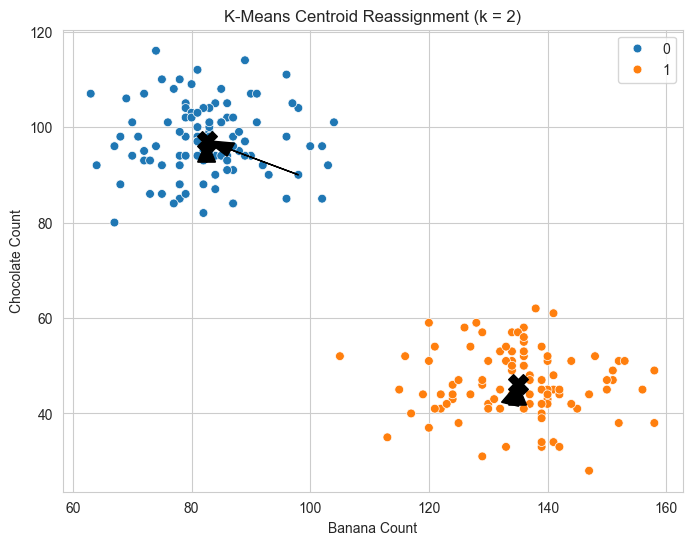

In [118]:
plt.figure(figsize=(8, 6))

# Determine dynamic k from final centroid shape
k_dynamic = centroid_history[-1].shape[0]

# Plot final clusters
sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=final_labels, 
    palette="tab10",
    s=40
)

# Plot centroid movement arrows
for i in range(1, len(centroid_history)):
    old = centroid_history[i - 1]
    new = centroid_history[i]

    for c in range(k_dynamic):
        plt.arrow(
            old[c, 0], old[c, 1],
            new[c, 0] - old[c, 0],
            new[c, 1] - old[c, 1],
            color="black",
            head_width=3,
            length_includes_head=True
        )

# Plot final centroids
for c in range(k_dynamic):
    plt.scatter(
        centroid_history[-1][c, 0],
        centroid_history[-1][c, 1],
        s=200,
        c="black",
        marker="X"
    )

plt.title(f"K-Means Centroid Reassignment (k = {k_dynamic})")
plt.xlabel("Banana Count")
plt.ylabel("Chocolate Count")
plt.show()

In [119]:
%matplotlib inline
from matplotlib import rc
rc('animation', html='jshtml')

In [120]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()

    labels = label_history[frame]
    centroids = centroid_history[frame]

    # extract the number of clusters from centroids shape
    k_dynamic = centroids.shape[0]

    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=labels,
        cmap="tab10",   # tab10 supports up to 10 clusters
        s=40
    )

    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        s=200,
        c="black",
        marker="X"
    )

    # Draw arrows 
    if frame > 0:
        old = centroid_history[frame - 1]
        new = centroid_history[frame]

        for c in range(k_dynamic):
            ax.arrow(
                old[c, 0], old[c, 1],
                new[c, 0] - old[c, 0],
                new[c, 1] - old[c, 1],
                color="black",
                head_width=3,
                length_includes_head=True
            )

    # Axes formatting
    ax.set_xlim(X[:, 0].min() - 10, X[:, 0].max() + 10)
    ax.set_ylim(X[:, 1].min() - 10, X[:, 1].max() + 10)
    ax.set_xlabel("Banana Count")
    ax.set_ylabel("Chocolate Count")
    ax.set_title(f"K-Means Iteration {frame} (k = {k_dynamic})")

ani = FuncAnimation(
    fig,
    update,
    frames=len(label_history),
    interval=1200,
    repeat=False
)

ani


In [121]:
# Add more text data

n = 100
vocabulary = ["banana", "chocolate"]

# Cluster 1: Dirichlet([1,2]), average length ~150
text_type_1 = [
    generate_text(
        theta=np.random.dirichlet([1, 2]),
        base_length=150,
        length_jitter=30
    )
    for _ in range(n)
]

# Cluster 2: Dirichlet([2,1]), average length ~150
text_type_2 = [
    generate_text(
        theta=np.random.dirichlet([2, 1]),
        base_length=150,
        length_jitter=30
    )
    for _ in range(n)
]

# Cluster 3: Dirichlet([50,50]), longer docs (~250 words)
text_type_3 = [
    generate_text(
        theta=np.random.dirichlet([50, 50]),
        base_length=250,
        length_jitter=40
    )
    for _ in range(500)
]

# Combine
all_texts = text_type_1 + text_type_2 + text_type_3
labels = [1]*n + [2]*n + [3]*500


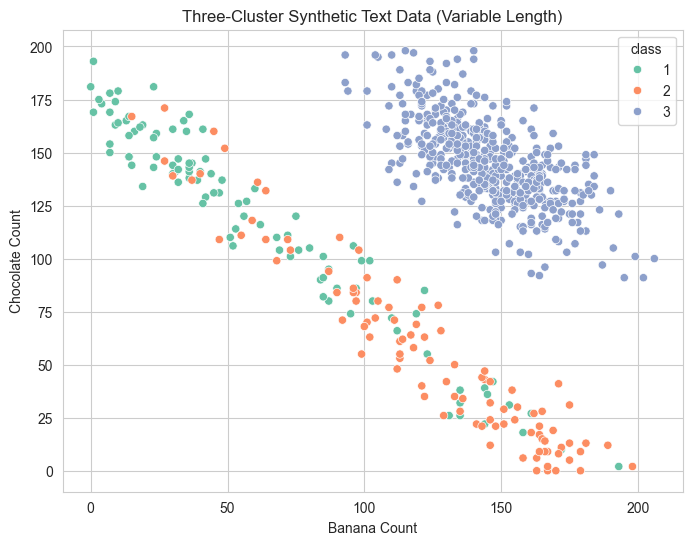

In [123]:
dtm = vectorizer.fit_transform(all_texts).toarray()
dtm_df = pd.DataFrame(dtm, columns=vocabulary)
dtm_df["class"] = labels

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dtm_df,
    x="banana", y="chocolate",
    hue="class", palette="Set2", legend="full"
)
plt.title("Three-Cluster Synthetic Text Data (Variable Length)")
plt.xlabel("Banana Count")
plt.ylabel("Chocolate Count")
plt.show()


In [128]:
X = dtm_df[["banana", "chocolate"]].values
k = 3
max_iter = 10


centroid_history, label_history, final_labels = manual_kmeans(
    X,
    k=k,
    max_iter=10,
    random_state=666
)


In [129]:
ani = FuncAnimation(
    fig,
    update,
    frames=len(label_history),
    interval=1200,
    repeat=False
)

ani

/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklea

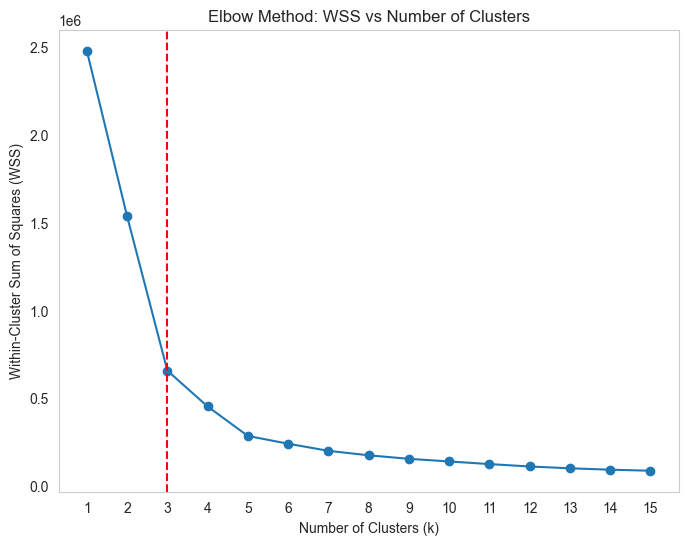

In [130]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def compute_wss(data, max_k=15):
    """
    Compute Within-Cluster Sum of Squares (WSS) for KMeans with k = 1..max_k.
    """
    wss = []
    for k in range(1, max_k + 1):
        model = KMeans(n_clusters=k, n_init=10, random_state=123)
        model.fit(data)
        wss.append(model.inertia_)   # WSS
    return wss

# Compute WSS
max_k = 15
wss_values = compute_wss(dtm, max_k)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), wss_values, marker='o')
plt.title("Elbow Method: WSS vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.axvline(3, color='red', linestyle='--', label='True k = 3')
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()


# Topic Modeling

## Better in r

In [77]:
!pip install gensim

/Users/petrotolochko/miniconda3/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=14097) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [104]:
import spacy

nlp = spacy.load("en_core_web_md", disable=["ner", "parser"])

def spacy_preprocess(text):
    """
    - tokenize
    - lowercase
    - remove stopwords
    - remove punctuation
    - lemmatize
    """
    doc = nlp(text)
    tokens = [
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha
        and not tok.is_stop
    ]
    return tokens

In [79]:
# Load the text data
sotu = pd.read_csv('sotu.csv')
# Inspect the data
print(sotu.head())


print(sotu['text'][0])

sotu = sotu[sotu['year'] >= 1901].reset_index(drop=True)

   X          president  year years_active        party sotu_type  \
0  1  George Washington  1790    1789-1793  Nonpartisan    speech   
1  2  George Washington  1790    1789-1793  Nonpartisan    speech   
2  3  George Washington  1791    1789-1793  Nonpartisan    speech   
3  4  George Washington  1792    1789-1793  Nonpartisan    speech   
4  5  George Washington  1793    1793-1797  Nonpartisan    speech   

                                                text  
0  Fellow-Citizens of the Senate and House of Rep...  
1  \n\n Fellow-Citizens of the Senate and House o...  
2  \n\n Fellow-Citizens of the Senate and House o...  
3  Fellow-Citizens of the Senate and House of Rep...  
4  \n\n Fellow-Citizens of the Senate and House o...  
Fellow-Citizens of the Senate and House of Representatives: 

I embrace with great satisfaction the opportunity which now presents itself of congratulating you on the present favorable prospects of our public affairs. The recent accession of the important

In [80]:
processed_docs = [spacy_preprocess(doc) for doc in sotu['text']]

In [ ]:
from gensim.corpora import Dictionary

# Create dictionary (word → id mapping)
dictionary = Dictionary(processed_docs)

dictionary.filter_extremes(
    no_below=5,      # remove words that appear in <= 5 docs
    no_above=0.95     # remove words that appear in >= 95% of the docs
)

# Bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [82]:
from gensim.models.ldamodel import LdaModel

num_topics = 5

lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

In [83]:
for i, topic in lda.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"Topic {i}: {[word for word, _ in topic]}")

Topic 0: ['law', 'public', 'present', 'department', 'service', 'interest', 'business', 'condition', 'court', 'large']
Topic 1: ['free', 'shall', 'force', 'freedom', 'security', 'defense', 'effort', 'military', 'program', 'problem']
Topic 2: ['america', 'help', 'americans', 'job', 'child', 'let', 'tonight', 'family', 'ask', 'tax']
Topic 3: ['program', 'federal', 'administration', 'effort', 'legislation', 'energy', 'development', 'million', 'propose', 'health']
Topic 4: ['law', 'shall', 'service', 'present', 'matter', 'public', 'mean', 'interest', 'duty', 'ship']


In [84]:
lda.print_topics(num_topics=5, num_words=5)

[(0,
  '0.009*"law" + 0.006*"public" + 0.005*"present" + 0.004*"department" + 0.004*"service"'),
 (1,
  '0.007*"free" + 0.006*"shall" + 0.005*"force" + 0.005*"freedom" + 0.004*"security"'),
 (2,
  '0.014*"america" + 0.007*"help" + 0.007*"americans" + 0.007*"job" + 0.007*"child"'),
 (3,
  '0.014*"program" + 0.011*"federal" + 0.007*"administration" + 0.006*"effort" + 0.005*"legislation"'),
 (4,
  '0.005*"law" + 0.004*"shall" + 0.004*"service" + 0.004*"present" + 0.004*"matter"')]

In [85]:
doc_topics = [lda.get_document_topics(bow) for bow in corpus]

doc_topics

[[(0, np.float32(0.9569152)),
  (1, np.float32(0.022793164)),
  (4, np.float32(0.010901487))],
 [(0, np.float32(0.9565133)), (4, np.float32(0.041710023))],
 [(0, np.float32(0.99984664))],
 [(0, np.float32(0.43051252)), (4, np.float32(0.5693884))],
 [(0, np.float32(0.9931689))],
 [(0, np.float32(0.96825343)), (2, np.float32(0.027470242))],
 [(0, np.float32(0.99983406))],
 [(0, np.float32(0.99269027))],
 [(0, np.float32(0.99983954))],
 [(0, np.float32(0.999902))],
 [(0, np.float32(0.99990654))],
 [(0, np.float32(0.996604))],
 [(0, np.float32(0.5832007)),
  (1, np.float32(0.18714218)),
  (4, np.float32(0.2292958))],
 [(4, np.float32(0.99938667))],
 [(4, np.float32(0.9996731))],
 [(0, np.float32(0.82104)), (4, np.float32(0.17814918))],
 [(0, np.float32(0.13003257)),
  (1, np.float32(0.75093013)),
  (4, np.float32(0.11868545))],
 [(0, np.float32(0.059050564)),
  (1, np.float32(0.24303013)),
  (4, np.float32(0.6976817))],
 [(0, np.float32(0.64699703)),
  (1, np.float32(0.33591002)),
  (4, np

In [86]:
!pip install pyLDAvis

/Users/petrotolochko/miniconda3/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=14097) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [87]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [88]:
# Prepare the visualization
vis = gensimvis.prepare(lda, corpus, dictionary)

pyLDAvis.enable_notebook()

vis
# Save the visualization to an HTML file
# pyLDAvis.save_html(vis, 'lda_visualization.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.107217  0.014636       1        1  31.160648
3      0.037009 -0.090554       2        1  25.648063
2      0.123190  0.051119       3        1  25.355516
1      0.004058  0.000618       4        1  15.197003
4     -0.057041  0.024181       5        1   2.638769, topic_info=          Term         Freq        Total Category  logprob  loglift
3712   program  1934.000000  1934.000000  Default  30.0000  30.0000
88     america  1728.000000  1728.000000  Default  29.0000  29.0000
1674     shall   809.000000   809.000000  Default  28.0000  28.0000
1094       law  1690.000000  1690.000000  Default  27.0000  27.0000
5244   tonight   566.000000   566.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1891     trade    22.109145   705.040756   Topic5  -6.0952   0.1726
989   industry    21.196575   542.250426   Topic5  -6.1374   0.3930
785      force    23.021443  1040.712759   Topic5  -6.0548  -0.1764
743    federal    23.539836  1636.206253   Topic5  -6.0325  -0.6066
1211   million    21.763431  1063.728626   Topic5  -6.1110  -0.2544

[438 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2863      1  0.371100    accustom
2863      2  0.247400    accustom
2863      5  0.247400    accustom
2865      2  0.379632  adaptation
2865      4  0.379632  adaptation
...     ...       ...         ...
2045      1  0.103058       young
2045      2  0.087790       young
2045      3  0.713770       young
2045      4  0.068705       young
2045      5  0.026719       young

[1311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

In [89]:
nlp = spacy.load("en_core_web_md", disable=["parser"])

def spacy_preprocess_no_ner(text):
    doc = nlp(text)
    tokens = []
    
    for tok in doc:
        # Remove tokens that belong to a named entity
        if tok.ent_type_ != "" and tok.ent_iob_ != "O":
            continue

        if tok.is_stop or tok.is_punct or tok.is_space:
            continue
        
        tokens.append(tok.lemma_)
    
    return tokens

In [90]:
spacy_preprocess_no_ner("Barack Obama visited New York to give a speech. USA, Great Britain, France")

['visit', 'speech']

In [91]:
processed_docs_no_ner = [spacy_preprocess_no_ner(doc) for doc in sotu['text']]

In [92]:
dictionary_no_ner = Dictionary(processed_docs_no_ner)

dictionary_no_ner.filter_extremes(
    no_below=5,      # remove words that appear in <= docs
    no_above=0.95     # remove words that appear in >= 95% of the docs
)

# Bag-of-words corpus
corpus_no_ner = [dictionary_no_ner.doc2bow(doc) for doc in processed_docs_no_ner]


num_topics = 5

lda = LdaModel(
    corpus=corpus_no_ner,
    id2word=dictionary_no_ner,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

In [93]:
vis = gensimvis.prepare(lda, corpus_no_ner, dictionary_no_ner)

pyLDAvis.enable_notebook()

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.099510  0.036040       1        1  35.317756
2      0.017215 -0.084035       2        1  23.605475
3      0.114339  0.030117       3        1  23.387622
0      0.007927  0.048104       4        1  10.038111
4     -0.039971 -0.030225       5        1   7.651036, topic_info=          Term         Freq        Total Category  logprob  loglift
3524   program  1831.000000  1831.000000  Default  30.0000  30.0000
1914       war  1330.000000  1330.000000  Default  29.0000  29.0000
1599     shall   835.000000   835.000000  Default  28.0000  28.0000
789       free   813.000000   813.000000  Default  27.0000  27.0000
1027       job   911.000000   911.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
769      force    82.776647   994.960867   Topic5  -5.7478   0.0838
1383  progress    74.942196   713.547226   Topic5  -5.8473   0.3168
1057       law    81.804853  1642.033271   Topic5  -5.7597  -0.4290
1914       war    79.020856  1330.205650   Topic5  -5.7943  -0.2530
1874       use    73.620651   723.820720   Topic5  -5.8651   0.2847

[445 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.746242      $
0         2  0.059402      $
0         3  0.141081      $
0         4  0.022276      $
0         5  0.031558      $
...     ...       ...    ...
1958      1  0.120418  young
1958      2  0.109128  young
1958      3  0.673586  young
1958      4  0.090313  young
1958      5  0.011289  young

[1379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

In [94]:
topic_range = [5, 10, 15, 20, 30]
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.1]
eta_values  = ['symmetric', 0.01, 0.1] # this is beta, but in gensim it's "eta"
passes_values = [5, 10, 15]

In [ ]:
from gensim.models import CoherenceModel

def evaluate_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        iterations=400,
        alpha=alpha,
        eta=eta,
        passes=passes,
    )
    
    # Compute coherence score
    coher = CoherenceModel(
        model=lda, 
        texts=texts, 
        dictionary=dictionary, 
        coherence='c_v'
    ).get_coherence()
    
    return coher, lda

In [96]:

results = []

for k in topic_range:
    for a in alpha_values:
        for eta in eta_values:
            for p in passes_values:
                
                coher, model = evaluate_lda_model(
                    corpus=corpus,
                    dictionary=dictionary,
                    texts=processed_docs, 
                    num_topics=k,
                    alpha=a,
                    eta=eta,
                    passes=p
                )
                
                results.append({
                    'k': k,
                    'alpha': a,
                    'eta': eta,
                    'passes': p,
                    'coherence': coher,
                    'model': model
                })
                
                print(f"k={k}, alpha={a}, eta={eta}, passes={p} → coherence={coher:.4f}")

k=5, alpha=symmetric, eta=symmetric, passes=5 → coherence=0.4351
k=5, alpha=symmetric, eta=symmetric, passes=10 → coherence=0.4573
k=5, alpha=symmetric, eta=symmetric, passes=15 → coherence=0.4578
k=5, alpha=symmetric, eta=0.01, passes=5 → coherence=0.4387
k=5, alpha=symmetric, eta=0.01, passes=10 → coherence=0.4569


Exception ignored in atexit callback <function _exit_function at 0x100f804a0>Exception ignored in atexit callback <function _exit_function at 0x103a4c4a0>:
Traceback (most recent call last):
:
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/Users/petrotolochko/miniconda3/lib/python3.13/ast.py:602: DeprecationWarning: Constant.__init__ got an unexpected keyword argument 's'. Support for arbitrary keyword arguments is deprecated and will be removed in Python 3.15.
  return Constant(*args, **kwargs)
/Users/petrotolochko/miniconda3/lib/python3.13/ast.py:602: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/Users/petrotolochko/miniconda3/lib/python3.13/ast.py:602: DeprecationWarning: Constant.__init__ missing 1 required positional arg

KeyboardInterrupt: 